In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn
import scipy
import pandas as pd
import matplotlib.pyplot as plt


from src.utils.utils import lp_error
from src.utils.logger import Logging
from src.utils.colors import model_color

from src.nn.tanh2 import MLP2
from src.nn.tanh import MLP
from src.nn.bspline import KAN
from src.nn.kan2 import KAN2
from src.utils.utils import clear_gpu_memory
from src.data.IBM_data_loader import prepare_training_data, visualize_tensor_datasets
from src.data.IBM_data_loader import load_fluid_testing_dataset
from src.models.m1 import PINNTrainer
from src.utils.plot_losses import plot_M1_loss_history
from src.utils.fsi_visualization import (
    create_frames,
    create_animations_from_existing_frames,
)
from src.data.IBM_data_loader import load_training_dataset


In [ ]:

CHECKPOINT_PATH = "./checkpoints/testing"
logger = Logging(CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(model_dirname)

clear_gpu_memory()
config = {
    "dataset_type": "old",
    "training_selection_method": "Sobol",
    "input_dim": 3,  # (x, y, z, t)
    "hidden_dim": 250,
    "hidden_layers_dim": 3,
    "fluid_density": 1.0,
    "fluid_viscosity": 0.01,
    "num_epochs": 60000,
    "batch_size": 256,
    "learning_rate": 1e-3,
    "data_weight": 2.0,
    "physics_weight": 0.01,
    "boundary_weight": 2.0,
    "fsi_weight": 0.5,
    "initial_weight": 4.0,
    "checkpoint_dir": CHECKPOINT_PATH,
    "print_every": 500,
    "save_every": 2000,
    "fluid_sampling_ratio": 0.01,
    "interface_sampling_ratio": 0.07,
    "solid_sampling_ratio": 0.0,
    "left_sampling_ratio": 0.1,
    "right_sampling_ratio": 0.15,
    "bottom_sampling_ratio": 0.1,
    "top_sampling_ratio": 0.1,
    "initial_sampling_ratio": 0.1,
    "device":  "cpu",
    "solver": "mlp",
    "model": "m1",
}


INFO:src.utils.logger:./checkpoints/testing/2025-08-17_14-16-35-476480


GPU memory cleared!


In [22]:
model_state["solver"]

'kan'

INFO:src.utils.logger:Number of parameters: 5453
/Users/afrahfarea/Desktop/afrah/code/pinn_fsi_ibm/src/utils/plot_losses.py:139: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=y_min)


final loss BC: 5.62e-01
final loss Physics: 1.52e-02
final loss FSI: 4.07e-05
final loss Initial: 5.52e-02
final loss Fluid total: 6.89e-01


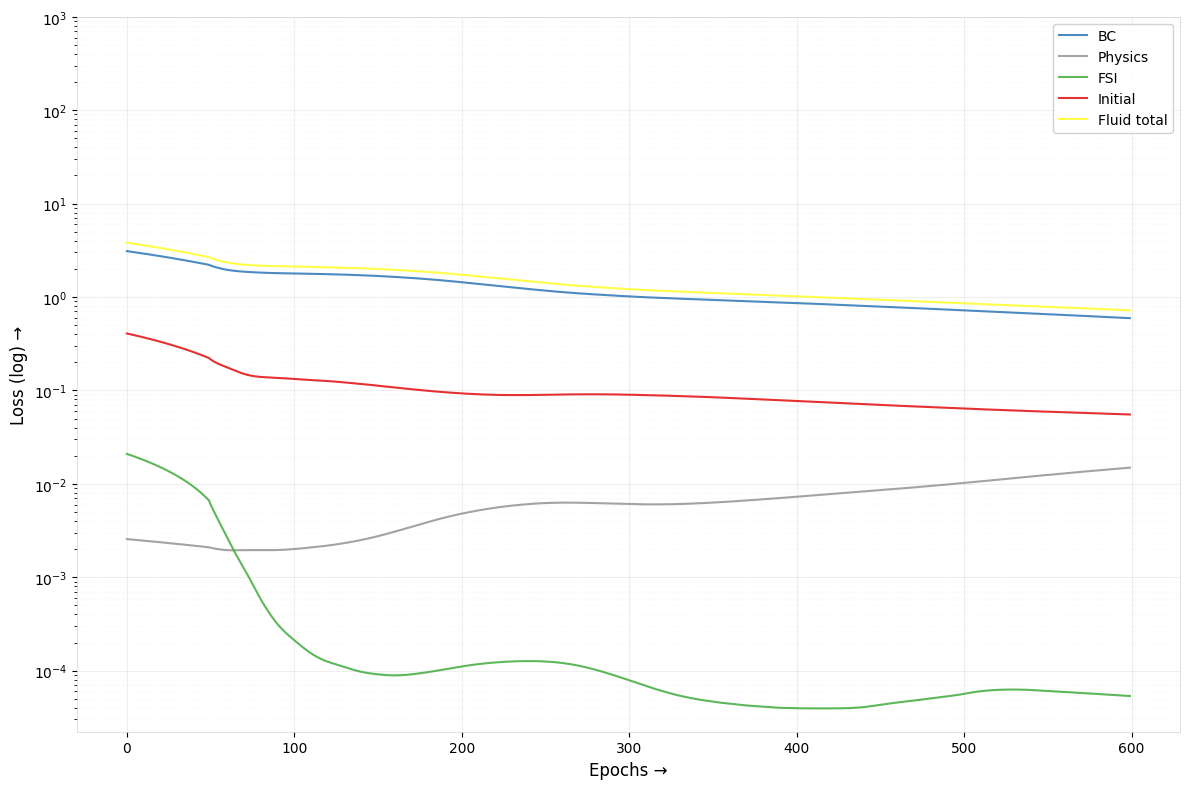

In [113]:
model_path = "./checkpoints/2025-08-17_22-11-00-832766/model.pth"#"./checkpoints/2025-08-17_00-29-12-363506/model.pth"#"./checkpoints/2025-08-17_00-25-12-195486/model.pth"#"./checkpoints/2025-08-16_18-14-52-209563/model.pth"#"./checkpoints/2025-08-15_19-40-16-627572/model.pth" #./checkpoints/2025-08-15_14-35-00-873250/model.pth
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model_state = torch.load(model_path, map_location=device)

if model_state["solver"] == "mlp":
    fluid_model = MLP(model_state["fluid_network"]).to(config["device"])
    solid_model = MLP(model_state["fluid_network"]).to(config["device"])
else:
    fluid_model = KAN2(model_state["fluid_network"]).to(config["device"])
    solid_model = KAN2(model_state["fluid_network"]).to(config["device"])



fluid_model.load_state_dict(model_state["fluid_model_state_dict"])
solid_model.load_state_dict(model_state["solid_model_state_dict"])

fluid_model.eval()
solid_model.eval()

logger.print(
    f"Number of parameters: {sum(p.numel() for p in fluid_model.parameters())}"
)


loss_history = model_state["loss_history"]

save_path = os.path.join(logger.get_output_dir(), "loss_history_M1.png")

plot_M1_loss_history(loss_history, save_path, y_max=1000, y_min=0, figsize=(12, 8))

In [114]:


animations_reference_dir = os.path.join(logger.get_output_dir(), "animations_reference")

try:
    testing_dataset = load_fluid_testing_dataset(config["dataset_type"])
except Exception as e:
    logger.print(f"Testing dataset not found.")
    raise e

skip = 1
time = testing_dataset[:, 0:1][::skip]
x = testing_dataset[:, 1:2][::skip]
y = testing_dataset[:, 2:3][::skip]
u_ref = testing_dataset[:, 3:4][::skip]
v_ref = testing_dataset[:, 4:5][::skip]
p_ref = testing_dataset[:, 5:6][::skip]


with torch.no_grad():
    outputs = fluid_model(torch.cat([time, x, y], dim=1).squeeze(1))

u_pred = outputs[:, 0:1]
v_pred = outputs[:, 1:2]
p_pred = outputs[:, 2:3]


velocity_magnitude_pred = torch.sqrt(u_pred**2 + v_pred**2)

rel_u_l2_error = (
    torch.sqrt(torch.mean((u_pred - u_ref) ** 2) / torch.mean(u_ref**2)) * 100
)
rel_v_l2_error = (
    torch.sqrt(torch.mean((v_pred - v_ref) ** 2) / torch.mean(v_ref**2)) * 100
)
rel_p_l2_error = (
    torch.sqrt(torch.mean((p_pred - p_ref) ** 2) / torch.mean(p_ref**2)) * 100
)

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")

INFO:src.utils.logger:Relative L2 error for u: 4.44e+01 %
INFO:src.utils.logger:Relative L2 error for v: 8.41e+01 %
INFO:src.utils.logger:Relative L2 error for p: 8.51e+01 %


In [115]:
processed_dataset_path = "./data/Fluid_trainingData.mat"
Fluid_data = scipy.io.loadmat(processed_dataset_path)

interface = Fluid_data["Solid_interface"]
solid = Fluid_data["Solid_points"]

with torch.no_grad():
    outputs_interface_m1 = np.array(
        solid_model(
            torch.cat(
                [
                    torch.tensor(solid[:, 0:1], dtype=torch.float32),
                    torch.tensor(solid[:, 1:2], dtype=torch.float32),
                    torch.tensor(solid[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        ).detach().numpy()
    )

u_pred_interface_m1 = outputs_interface_m1[:, 0:1]
v_pred_interface_m1 = outputs_interface_m1[:, 1:2]
p_pred_interface_m1 = outputs_interface_m1[:, 2:3]


logger.print(f"On the interface")

rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_interface_m1 - np.array(solid[:, 3:4])) ** 2)
        / np.mean(np.array(interface[:, 3:4]) ** 2)
    )
    * 100
)

rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_interface_m1 - np.array(solid[:, 4:5])) ** 2)
        / np.mean(np.array(interface[:, 4:5]) ** 2)
    )
    * 100
)

rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_interface_m1 - np.array(solid[:, 5:6])) ** 2)
        / np.mean(np.array(interface[:, 5:6]) ** 2)
    )
    * 100
)


logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


INFO:src.utils.logger:On the interface
INFO:src.utils.logger:Relative L2 error for u: 8.42e+01 %
INFO:src.utils.logger:Relative L2 error for v: 8.21e+01 %
INFO:src.utils.logger:Relative L2 error for p: 5.17e+01 %


In [ ]:
INFO:src.utils.logger:On the interface
INFO:src.utils.logger:Relative L2 error for u: 8.30e+01 %
INFO:src.utils.logger:Relative L2 error for v: 8.71e+01 %
INFO:src.utils.logger:Relative L2 error for p: 1.11e+02 %

SyntaxError: invalid syntax (2606082153.py, line 1)

In [ ]:
INFO:src.utils.logger:On the interface
INFO:src.utils.logger:Relative L2 error for u: 7.82e+00 %
INFO:src.utils.logger:Relative L2 error for v: 8.62e+00 %
INFO:src.utils.logger:Relative L2 error for p: 3.39e+01 %

In [ ]:


animations_pred_dir = os.path.join(logger.get_output_dir(), "animations_pred")

prediction_df = pd.DataFrame(
    {
        "time": time.detach().numpy().flatten(),
        "x": x.detach().numpy().flatten(),
        "y": y.detach().numpy().flatten(),
        "pressure": p_pred.detach().numpy().flatten(),
        "u_x": u_pred.detach().numpy().flatten(),
        "v_y": v_pred.detach().numpy().flatten(),
        "velocity_magnitude": np.sqrt(
            u_pred.detach().numpy().flatten() ** 2
            + v_pred.detach().numpy().flatten() ** 2
        ),
    }
)

create_frames(prediction_df, output_dir=animations_pred_dir, sample_rate=10)


testing_df = pd.DataFrame(
    {
        "time": time.detach().numpy().flatten(),
        "x": x.detach().numpy().flatten(),
        "y": y.detach().numpy().flatten(),
        "pressure": p_ref.detach().numpy().flatten(),
        "u_x": u_ref.detach().numpy().flatten(),
        "v_y": v_ref.detach().numpy().flatten(),
        "velocity_magnitude": np.sqrt(
            u_ref.detach().numpy().flatten() ** 2
            + v_ref.detach().numpy().flatten() ** 2
        ),
    }
)
create_frames(testing_df, output_dir=animations_reference_dir, sample_rate=10)

create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_reference_dir, "pressure"),
        os.path.join(animations_reference_dir, "u_x"),
        os.path.join(animations_reference_dir, "v_y"),
        os.path.join(animations_reference_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_reference_dir, "gif"),
)
create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_pred_dir, "pressure"),
        os.path.join(animations_pred_dir, "u_x"),
        os.path.join(animations_pred_dir, "v_y"),
        os.path.join(animations_pred_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_pred_dir, "gif"),
)


  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/testing/2025-08-15_18-19-15-436724/animations_pred/pressure
  Processing time step 0.00 (1/11)
  Processing time step 0.10 (2/11)
  Processing time step 0.20 (3/11)
  Processing time step 0.30 (4/11)
  Processing time step 0.40 (5/11)
  Processing time step 0.50 (6/11)
  Processing time step 0.60 (7/11)
  Processing time step 0.70 (8/11)
  Processing time step 0.80 (9/11)
  Processing time step 0.90 (10/11)
  Processing time step 1.00 (11/11)
Saved frames to ./checkpoints/testing/2025-08-15_18-19-15-436724/animations_pred/velocity_magnitude
  Processing time step 0.00 (1/11)
 